In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench import Policy
import seaborn as sns
from ema_workbench import save_results
from ema_workbench import ScalarOutcome

Starts with importing all the modules nessecary for this program. After that the model gets loaded with at first a simplistic problem formulation. With the choice of the "1" value in problem formulation the model will focus on the following aspects: Expected damages, costs, and casualties.

After that a reference case will be made for further analysis.

In [2]:
model, planning_steps = get_model_for_problem_formulation(1)


reference_scenario = Scenario('reference', **{'A.0_ID flood wave shape': 4,
                                              'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

After this reference scenario an analysis will be done to determine the ideal amount of runs and epsilon value for this optimisation. This will be done by looping through different values. The goal is to get the highest total epsilon value with runs giving a stagnating line. This meaning further improvement is marginal to non existent. By choosing 4 runs for the amount of runs and 4 for the epsilon leads to a 16 run amount of analysis.

In [3]:
for i in range(4): # range 4 for trying  4 different amounts of runs
    convergence_metrics = [EpsilonProgress()]
    nfe = 10**(i+2) # the amount of runs.
    for j in range(4):
        epsilon = [0.01*(10**j),] * len(model.outcomes) # the episol value
        print(i,j) # for oversight print statement


        ema_logging.log_to_stderr(ema_logging.INFO)
        with MultiprocessingEvaluator(model) as evaluator: # starts the analysis
            total = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, reference= reference_scenario, convergence  = convergence_metrics )
            df, convergence = total
            print(len(df)) # print the amount of optimal runs.

            # saves the figure and csv of the expiriment
            fig, ax = plt.subplots()
            ax.plot(convergence.nfe, convergence.epsilon_progress)
            ax.set_ylabel('$\epsilon$-progress')
            ax.set_xlabel('number of function evaluations')
            plt.savefig(f'variant{i,j}.png')
            df.to_csv(f'data{i,j}.csv')

0 0


KeyboardInterrupt: 

figure 3,0 was chosen for further expirimentations because it had the lowest amount of the runs that lead to a stagnating line. This while having the highest epsilon value of the ones that did lead to stagnating line.

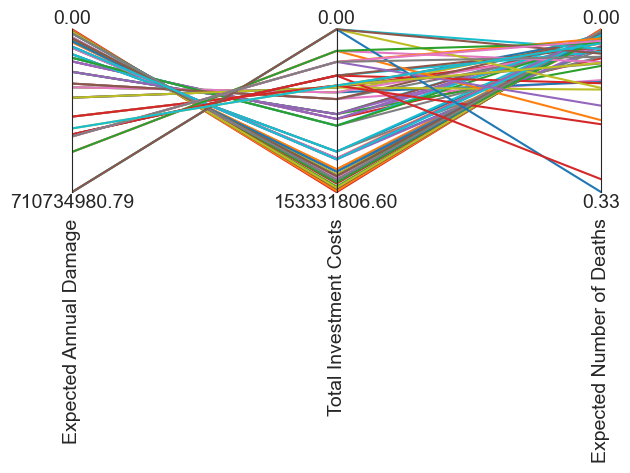

In [4]:
df = pd.read_csv("data(3, 0).csv") # loads the selected csv
data = df.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0 #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns) #reverses the x because minimizing is the goal
plt.show()

The current parcoords graph is currently not really readable because of all the solutions presentented.
While technically annual damage is a form of cost just like investment so for the inital cost in budget for the years is smaller.  For this purpose they will get added together this will focus the cost mostly on the first year.

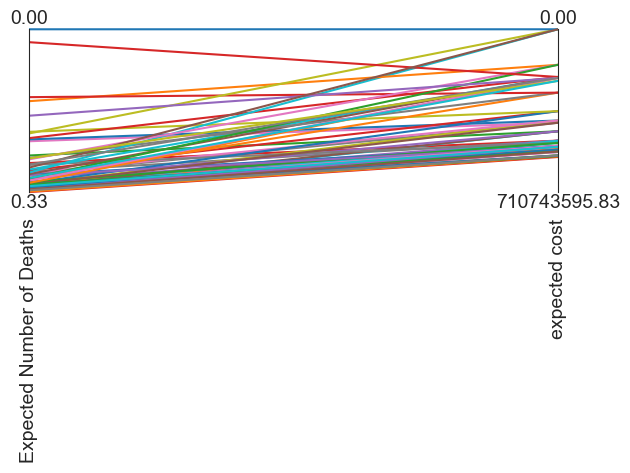

In [5]:
df = pd.read_csv("data(3, 0).csv")
df["expected cost"] = df["Expected Annual Damage"] + df["Total Investment Costs"]
data = df.loc[:, ['Expected Number of Deaths', "expected cost"]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0 #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns) #reverses the x because minimizing is the goal
plt.show()

On basis of this graph we will make a selection of policies. We decided for policies with a cost of 350000000 in the first year and less than 0.005 because risks of life should be minimal.

In [6]:
limiting = df.loc[(df['expected cost'] <= 350000000) & (df['Expected Number of Deaths'] <= 0.005)] # finds policies with low death and cost
display(limiting) # counts the amount of policies with those limits

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,expected cost
2,2,0,0,0,0,0,0,0,0,0,...,3,0,0,4,0,0,4.492434e+06,1.511265e+08,0.003916,1.556189e+08
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,4.297708e+07,1.368748e+08,0.004756,1.798519e+08
13,13,0,0,0,0,0,0,0,0,0,...,3,0,0,4,0,0,0.000000e+00,1.533318e+08,0.000000,1.533318e+08
21,21,0,0,0,0,0,0,0,0,0,...,2,0,0,4,0,0,3.976192e+06,1.522105e+08,0.001079,1.561867e+08
25,25,0,0,0,0,0,0,0,0,0,...,2,0,0,4,0,0,8.426604e+06,1.500051e+08,0.004977,1.584317e+08
46,46,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,3.467580e+07,1.403765e+08,0.004175,1.750523e+08
48,48,0,0,0,0,0,0,0,0,0,...,2,0,0,3,0,0,1.065800e+07,1.491849e+08,0.004023,1.598429e+08
57,57,0,0,0,0,0,0,0,0,0,...,2,0,0,3,0,0,1.821715e+07,1.419555e+08,0.003656,1.601726e+08


From these selected policies again a parcoords graph gets created.

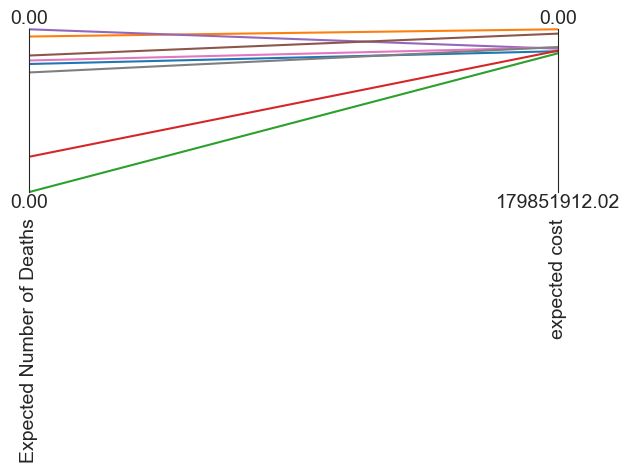

In [7]:
data = limiting.loc[:, ['Expected Number of Deaths', "expected cost"]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0 #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns) #reverses the x because minimizing is the goal
plt.show()

After having created these policies, we need to test them through more of than just the single reference scenario. Thus these optimised policies get tested through more scenarios. But to test these policies correctly the results are dropped from the reference and thus only leaving us with the policy choices.

In [8]:
policy_advice = limiting
policies = policy_advice.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns= ["expected cost"])
display(policies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2,2,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,4,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,2,0,0
13,13,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
21,21,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,4,0,0
25,25,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,4,0,0
46,46,0,0,0,0,0,0,0,0,0,...,0,4,0,0,1,0,0,2,0,0
48,48,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,3,0,0
57,57,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,3,0,0


We save these policies for later in the analysis

In [39]:
policies.to_csv("pf1 pollicy.csv")

In [8]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

This simulates the policy in 1000 different scenarios. This allows us to gain insight of policy in different circumstances.


In [22]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [04:41<00:00, 28.47it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


We save the results of the exiperment. in cases of crashes or other strange circumstances.

In [23]:
save_results(results, 'Mordor_policy_results')
experiments, outcomes = results

[MainProcess/INFO] results saved successfully to C:\Users\Alex\Downloads\epa1361_open-master\epa1361_open-master\final assignment\Mordor_policy_results


These policies will need to be compared over the different scenario's and to each other because of that we start with with taking for each policy the mean result.

In [24]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = np.mean(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
means = pd.DataFrame.from_dict(overall_scores).T
means

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
13,5.991752e+08,1.533448e+08,0.059287
2,6.550302e+08,1.511265e+08,0.593578
21,6.033148e+08,1.522105e+08,0.495098
25,6.591674e+08,1.500051e+08,0.594712
46,6.750093e+08,1.403848e+08,0.200165
48,6.209923e+08,1.491849e+08,0.511511
5,7.084206e+08,1.368838e+08,0.226929
57,6.993681e+08,1.419643e+08,0.226493


Then we create a function to transform the data using it's mean and standard deviation to a score metric.

In [9]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

This function then will get used on our experiments results.

In [10]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

NameError: name 'experiments' is not defined

Then to compare these results we plot them again in a parcoords graph.

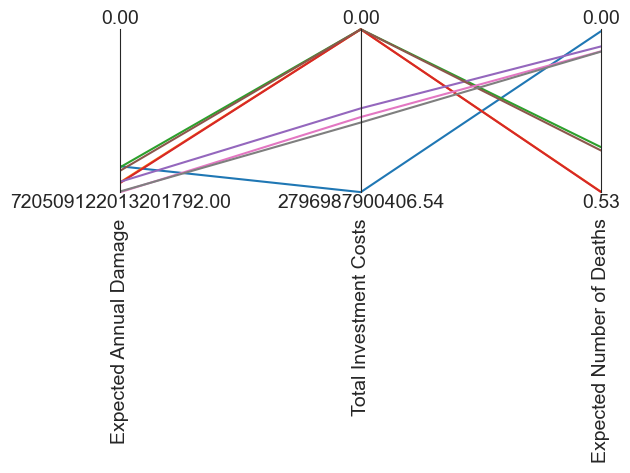

In [27]:
data = scores.round(3)
limits = parcoords.get_limits(data)
limits.loc[0, data.columns] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(scores.columns)
plt.show()

Another way to calculate and compare these graphs is with the regret. This function will compare how much the result difference from the best result.

In [11]:
def calculate_regret(data, best):
    return np.abs(best-data)

This will then be applied to the policy results.

In [29]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


This regret will then be shown in a heatmap. Where 1 is bad and 0 is good.

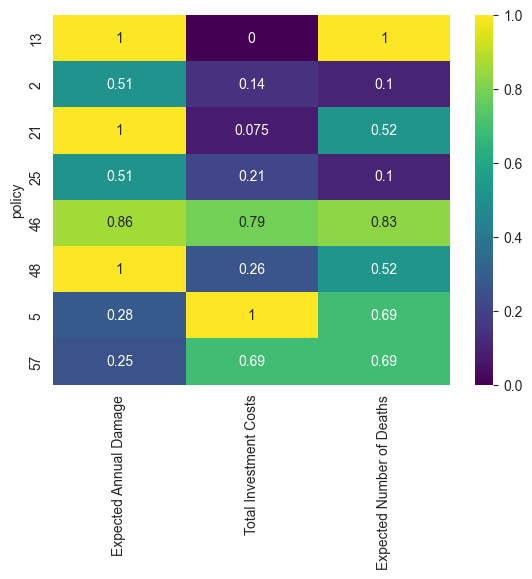

In [30]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [31]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]


Another way to show the regret is with a spread. Where results per attemt are spread in a boxplot.

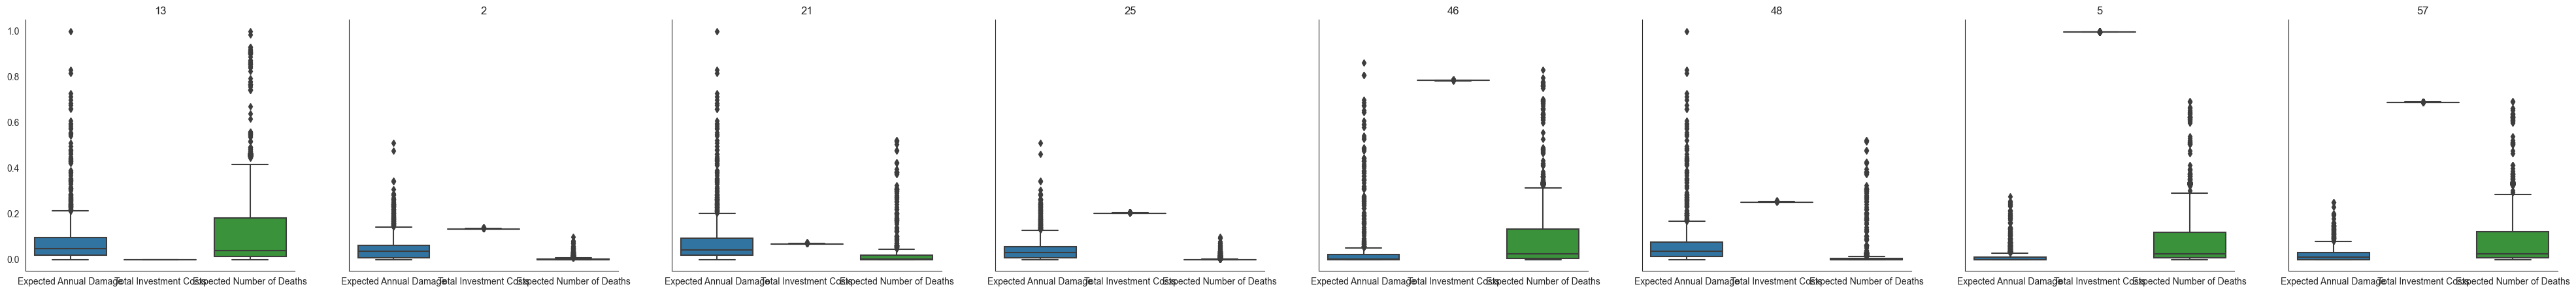

In [32]:
# this generates plots for the 8 policies with a shared y and x axis
fig, axes = plt.subplots(ncols=8, figsize=(50,5),
                         sharey=True, sharex=True)
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    sns.despine()
    ax.set_title(str(policy))
plt.savefig('policy spread.png')
plt.show()

We did all these steps for problem formulation 1, but this may lead to some provinces getting a heavier burden than others so now the analysis will be repeated with problem formulation 3 that splits the cost to cost per dijk ring.

In [10]:
model2, planning_steps = get_model_for_problem_formulation(3)


reference_scenario = Scenario('reference', **{'A.0_ID flood wave shape': 4,
                                              'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

0 0



100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.96it/s]
[MainProcess/INFO] optimization completed, found 70 solutions


70
0 1



100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.36it/s]
[MainProcess/INFO] optimization completed, found 74 solutions


74
0 2



100%|████████████████████████████████████████| 100/100 [00:04<00:00, 24.90it/s]
[MainProcess/INFO] optimization completed, found 61 solutions


61
0 3



100%|████████████████████████████████████████| 100/100 [00:03<00:00, 25.08it/s]
[MainProcess/INFO] optimization completed, found 79 solutions


79
1 0



100%|██████████████████████████████████████▊| 996/1000 [00:46<00:00, 24.34it/s]
1096it [00:50, 21.68it/s]                                                      
[MainProcess/INFO] optimization completed, found 250 solutions


250
1 1



100%|██████████████████████████████████████▉| 997/1000 [00:37<00:00, 26.23it/s]
1097it [00:41, 26.50it/s]                                                      
[MainProcess/INFO] optimization completed, found 283 solutions


283
1 2



100%|██████████████████████████████████████| 1000/1000 [00:39<00:00, 25.26it/s]
[MainProcess/INFO] optimization completed, found 266 solutions


266
1 3



100%|██████████████████████████████████████▉| 999/1000 [00:38<00:00, 26.26it/s]
1098it [00:42, 25.83it/s]                                                      
[MainProcess/INFO] optimization completed, found 337 solutions


337
2 0



100%|████████████████████████████████████▊| 9960/10000 [07:08<00:01, 22.55it/s]
13431it [09:49, 22.80it/s]                                                     
[MainProcess/INFO] optimization completed, found 1338 solutions


1338
2 1



100%|████████████████████████████████████▊| 9960/10000 [06:34<00:01, 24.68it/s]
12906it [08:42, 24.68it/s]                                                     
[MainProcess/INFO] optimization completed, found 1182 solutions


1182
2 2



100%|████████████████████████████████████▉| 9969/10000 [06:54<00:01, 24.02it/s]
12757it [08:54, 23.85it/s]                                                     
[MainProcess/INFO] optimization completed, found 1191 solutions


1191
2 3



100%|████████████████████████████████████▊| 9962/10000 [07:21<00:01, 21.48it/s]
12906it [09:37, 22.37it/s]                                                     
[MainProcess/INFO] optimization completed, found 1269 solutions


1269
3 0



 98%|████████████████████████████████▏| 97619/100000 [1:40:32<02:34, 15.43it/s]
100447it [1:43:11, 16.22it/s]                                                  
[MainProcess/INFO] optimization completed, found 3903 solutions


3903
3 1



 99%|████████████████████████████████▋| 99108/100000 [2:08:19<01:37,  9.11it/s]
102080it [2:13:44, 12.72it/s]                                                  
[MainProcess/INFO] optimization completed, found 3888 solutions


3888
3 2



 98%|████████████████████████████████▎| 97744/100000 [2:45:44<04:23,  8.57it/s]
100772it [2:51:46,  9.78it/s]                                                  
[MainProcess/INFO] optimization completed, found 4085 solutions


4085
3 3



100%|████████████████████████████████▉| 99832/100000 [2:35:08<00:18,  9.18it/s]
102828it [2:40:46, 10.66it/s]                                                  
[MainProcess/INFO] optimization completed, found 4131 solutions


4131


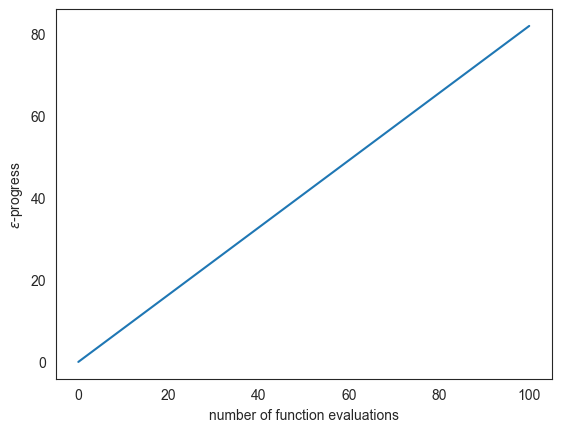

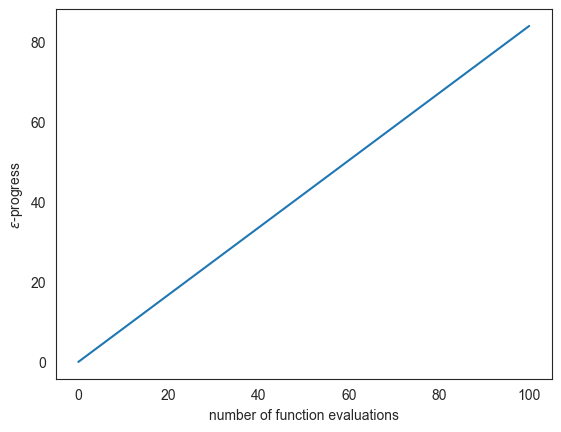

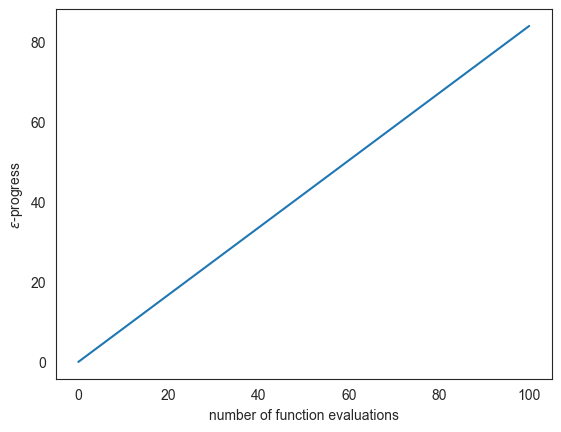

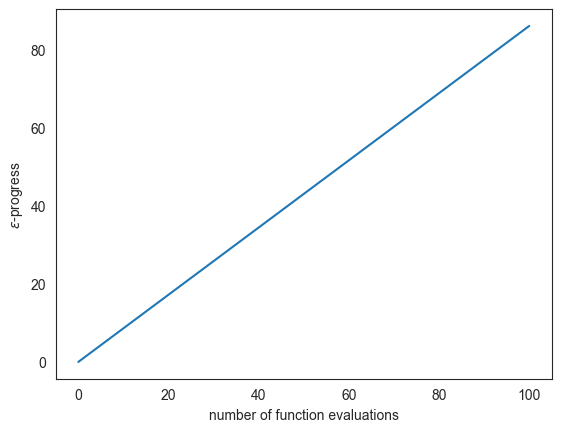

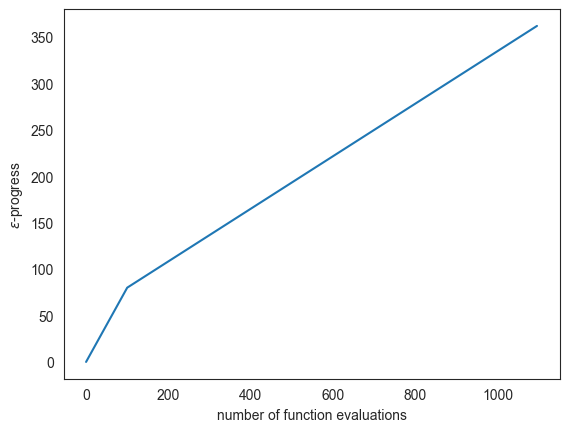

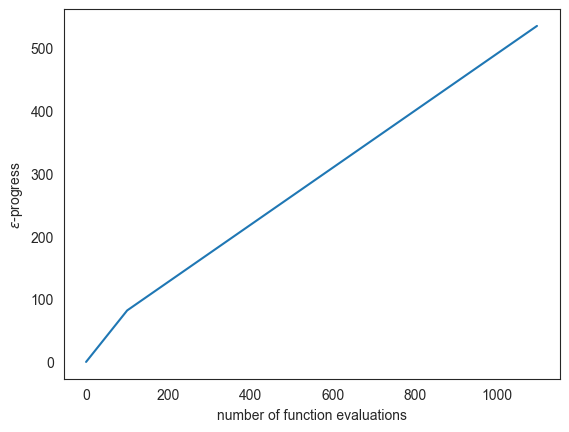

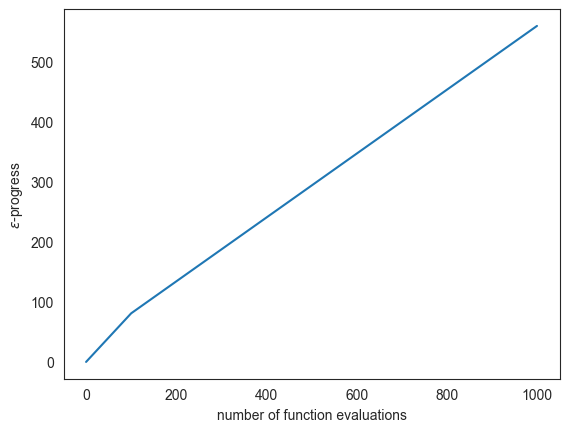

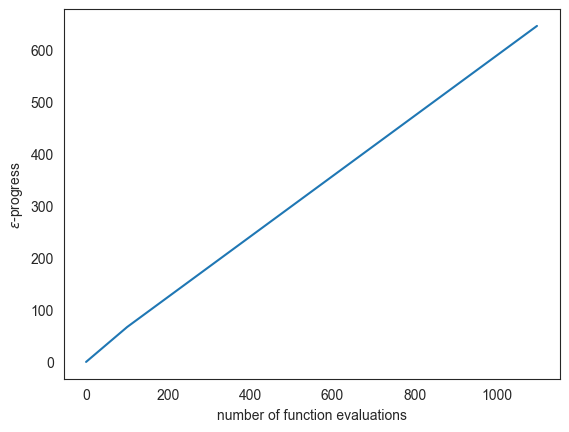

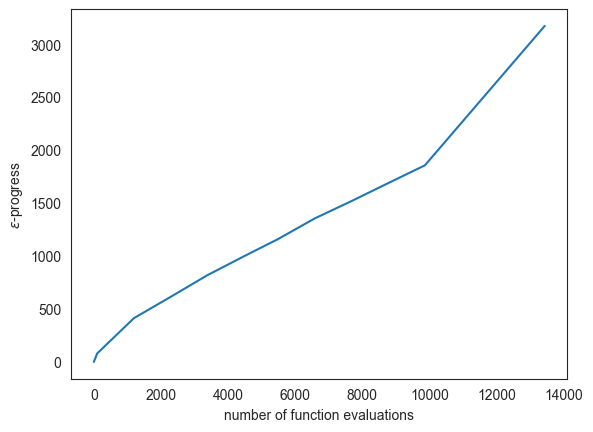

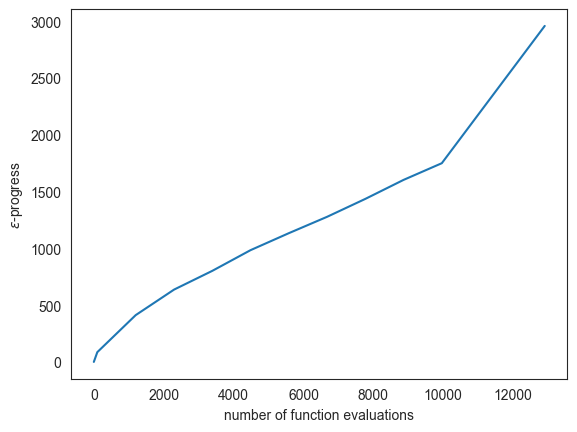

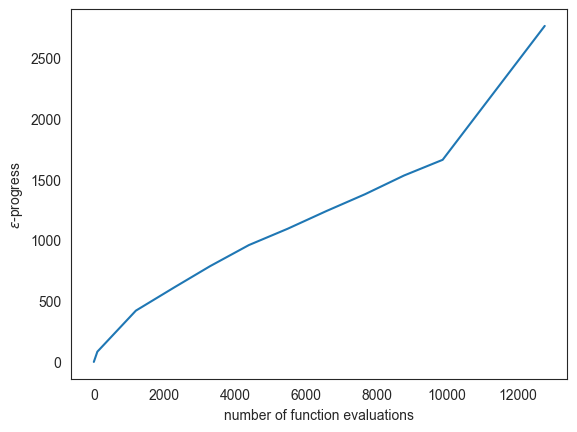

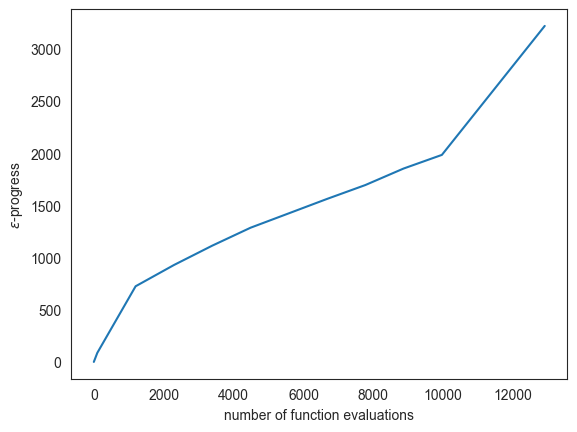

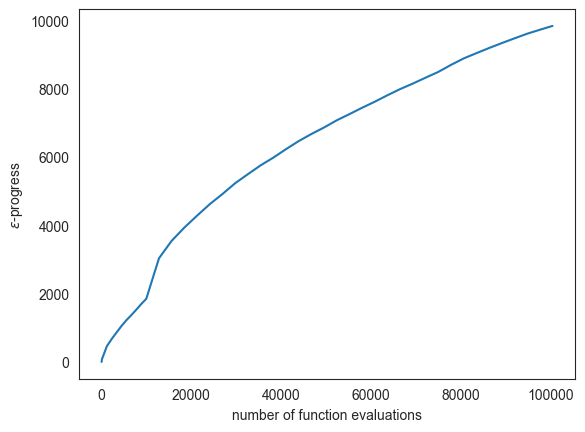

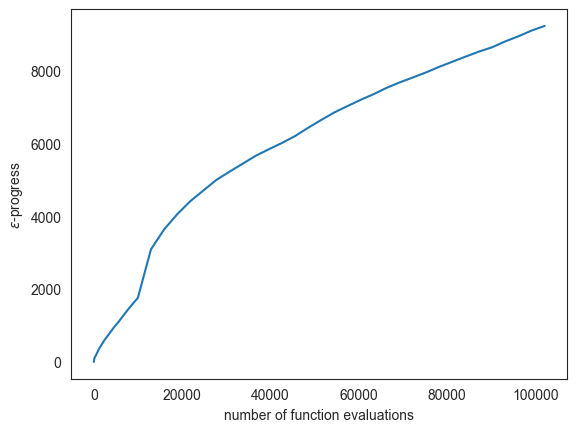

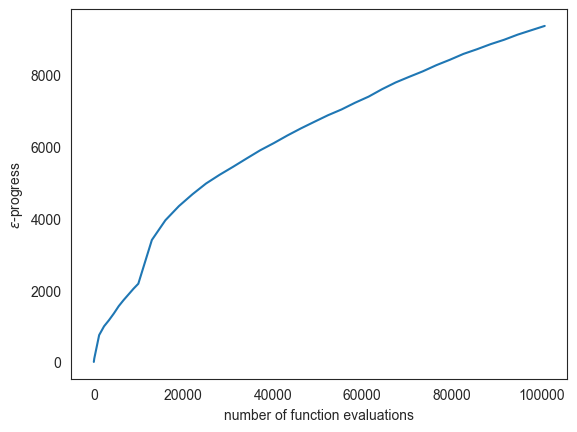

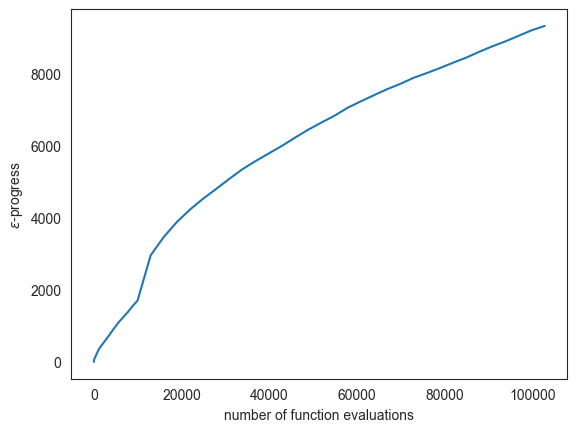

In [35]:
for i in range(4):
    convergence_metrics = [EpsilonProgress()]
    nfe = 10**(i+2)
    for j in range(4):
        epsilon = [0.1*(10**j),] * len(model2.outcomes)
        print(i,j)


        ema_logging.log_to_stderr(ema_logging.INFO)
        with MultiprocessingEvaluator(model2) as evaluator:
            total = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, reference= reference_scenario, convergence  = convergence_metrics )
            df, convergence = total
            print(len(df))


            fig, ax = plt.subplots()
            ax.plot(convergence.nfe, convergence.epsilon_progress)
            ax.set_ylabel('$\epsilon$-progress')
            ax.set_xlabel('number of function evaluations')
            plt.savefig(f'expanded_variant{i,j}.png')
            df.to_csv(f'expanded_data{i,j}.csv')

Because the results were not conclusive, the experiment gets repeated 1 more time with a really high NFE and epsilon, but even if it doesn't converge this will be the last one because this one takes roughly 24 hours to run on group's most powerful PC.

In [13]:
convergence_metrics = [EpsilonProgress()]
nfe = 1000000
epsilon = [10,] * len(model2.outcomes)
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model2) as evaluator:
    total = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, reference= reference_scenario, convergence  = convergence_metrics )
df, convergence = total
print(len(df))
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.savefig(f'hope2.png')
df.to_csv(f'hope2.csv')


KeyboardInterrupt: 

C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


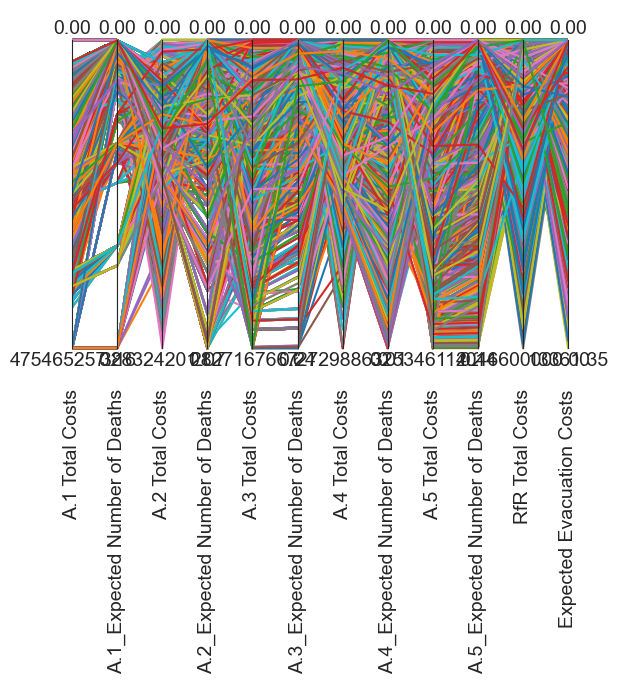

In [11]:
df = pd.read_csv("hope2.csv")
data = df.loc[:, [o.name for o in model2.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0  #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns)  #reverses the x because minimizing is the goal
plt.show()

In [12]:
print(df.columns)

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')


Here the cost from all dike rings together gets combined so it could be roughly equal to the first policy set. Deaths toll are lowered to 0.002 instead of the 0.005 but because it's in 5 regions it technically could end up higher then in the first problem formulation

In [13]:
df["expected cost"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"] +df["RfR Total Costs"] +df["Expected Evacuation Costs"]

limiting2 = df.loc[(df['expected cost'] <= 350000000) & (df['A.1_Expected Number of Deaths'] <= 0.002) & (df['A.2_Expected Number of Deaths'] <= 0.002) & (df['A.3_Expected Number of Deaths'] <= 0.002) & (df['A.4_Expected Number of Deaths'] <= 0.002) & (df['A.5_Expected Number of Deaths'] <= 0.002)]# finds policies with low death and cost
display(limiting2) # counts the amount of policies with those limits


,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,expected cost
63,63,0,0,0,0,0,0,1,1,0,...,0.000000,5.211741e+07,0.000869,3.028933e+07,0.000000,7.944417e+07,0.000000,61400000.0,114.880322,3.481937e+08
2089,2089,0,0,0,0,0,0,0,0,0,...,0.001269,5.281117e+07,0.000000,2.487483e+07,0.001770,6.287963e+07,0.001344,0.0,490.894036,3.495022e+08
2231,2231,0,0,0,0,0,0,0,1,0,...,0.000222,4.665017e+07,0.000000,3.960033e+07,0.001009,3.035153e+07,0.000000,30700000.0,1166.700283,3.469353e+08


In [14]:
policy_advice2 = limiting2
policies2 = policy_advice2.drop([o.name for o in model2.outcomes], axis=1)
policies2 = policies2.drop(columns= ["expected cost"])
display(policies2)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
63,63,0,0,0,0,0,0,1,1,0,...,0,1,3,0,3,5,2,4,6,0
2089,2089,0,0,0,0,0,0,0,0,0,...,3,5,1,0,1,0,0,2,1,0
2231,2231,0,0,0,0,0,0,0,1,0,...,0,3,0,1,0,0,1,3,0,0


In [40]:
policies2.to_csv("pf 3 policies.csv")

In [15]:
policies_to_evaluate = []

for i, policy in policies2.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_scenarios = 1000
with MultiprocessingEvaluator(model2) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
100%|██████████████████████████████████████| 3000/3000 [03:43<00:00, 13.41it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
save_results(results, 'Mordor_policy2_results')
experiments, outcomes = results
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in model2.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = np.mean(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
means = pd.DataFrame.from_dict(overall_scores).T
means

[MainProcess/INFO] results saved successfully to C:\Users\Alex\Downloads\epa1361_open-master\epa1361_open-master\final assignment\Mordor_policy2_results


,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
2089,1.214368e+08,0.005234,1.332294e+08,0.010775,7.599494e+07,0.015695,3.524054e+07,0.004980,1.096471e+08,0.018807,0.0,4486.178765
2231,1.649074e+08,0.001400,8.081752e+07,0.003664,1.008912e+08,0.011389,4.415756e+07,0.002149,6.883804e+07,0.004356,30700000.0,10419.549681
63,3.965839e+08,0.033554,6.935248e+07,0.002932,8.765535e+07,0.011050,3.336263e+07,0.000218,8.822996e+07,0.001289,61400000.0,6537.955086


In [17]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model2.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
2089,2.307350e+16,0.000248,1.304819e+16,0.000329,9.663368e+15,0.001324,1.513709e+15,3.390965e-05,1.505514e+16,0.000868,0.0,2.686675e+07
2231,2.526860e+16,0.000017,8.443186e+15,0.000041,2.062202e+16,0.000482,2.053809e+15,5.215150e-06,7.976233e+15,0.000057,0.0,1.477401e+08
63,2.799003e+17,0.002452,5.682538e+15,0.000031,1.327742e+16,0.000426,3.154488e+14,1.327109e-07,2.679517e+15,0.000006,0.0,6.035020e+07


C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


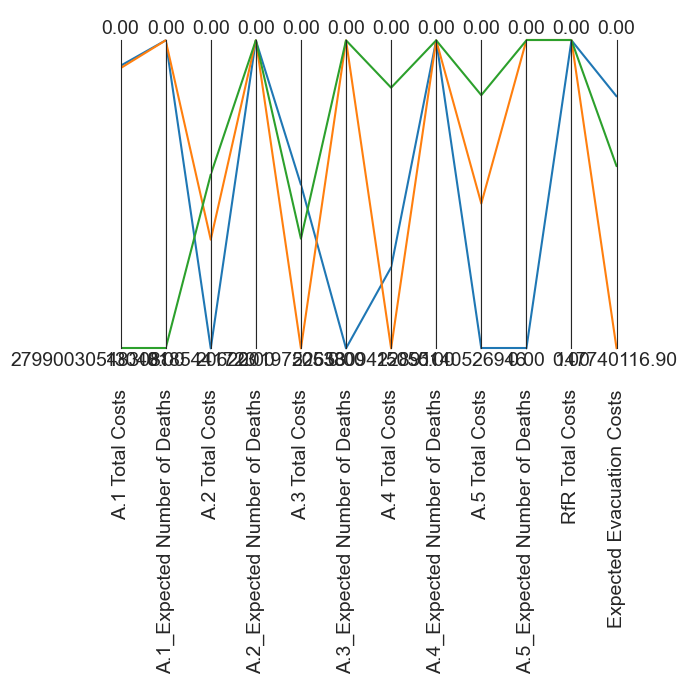

In [18]:
data = scores.round(3)
limits = parcoords.get_limits(data)
limits.loc[0, data.columns] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(scores.columns)
plt.show()

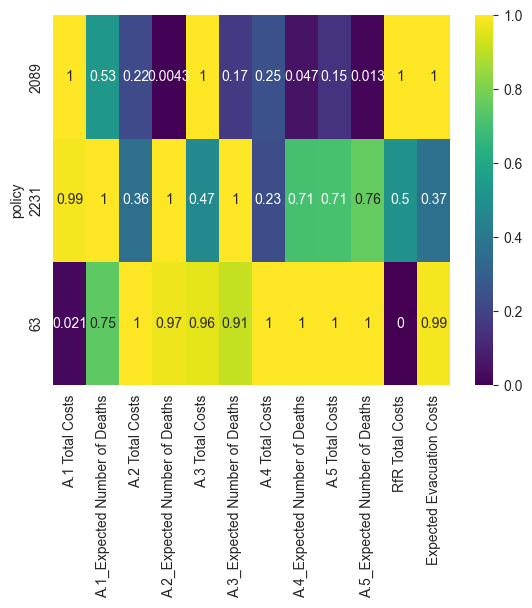

In [19]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model2.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy": experiments['policy'],
                         "scenario": experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret / max_regret.max(), cmap='viridis', annot=True)
plt.show()

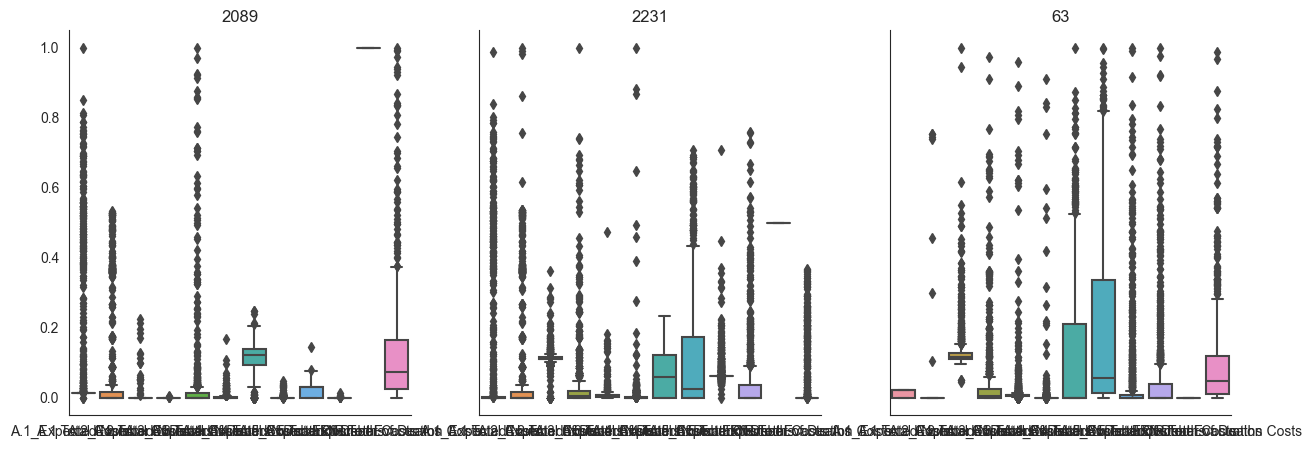

In [20]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

# this generates plots for the 8 policies with a shared y and x axis
fig, axes = plt.subplots(ncols=3, figsize=(15, 5),
                         sharey=True, sharex=True)
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data / max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    sns.despine()
    ax.set_title(str(policy))
plt.savefig('policy spread.png')
plt.show()

Now the polcies found with the use of problem formulation 1 and problem formulation 3 get combined to a pollicy set. Here the logic of both policies can be compared to eachother instead of the vacuum of it's own statement. So all the comparison tools from the previous two get repeated again.

In [21]:
allpolicieslist = [policies, policies2]
allpolicies = pd.concat(allpolicieslist, ignore_index=True)
display(allpolicies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,2,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,4,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,2,0,0
2,13,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
3,21,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,4,0,0
4,25,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,4,0,0
5,46,0,0,0,0,0,0,0,0,0,...,0,4,0,0,1,0,0,2,0,0
6,48,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,3,0,0
7,57,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,3,0,0
8,63,0,0,0,0,0,0,1,1,0,...,0,1,3,0,3,5,2,4,6,0
9,2089,0,0,0,0,0,0,0,0,0,...,3,5,1,0,1,0,0,2,1,0


In [41]:
allpolicies.to_csv("Policy.csv")

In [22]:
policies_to_evaluate = []

for i, policy in allpolicies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_scenarios = 10000
with MultiprocessingEvaluator(model2) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 10000 scenarios * 11 policies * 1 model(s) = 110000 experiments
100%|████████████████████████████████| 110000/110000 [1:44:44<00:00, 17.50it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [26]:
save_results(results, 'Mordor_policy3_results')
experiments, outcomes = results
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in model2.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = np.mean(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
means = pd.DataFrame.from_dict(overall_scores).T
means

[MainProcess/INFO] results saved successfully to C:\Users\Alex\Downloads\epa1361_open-master\epa1361_open-master\final assignment\Mordor_policy3_results


,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,4.536656e+08,0.286002,8.782210e+07,0.037128,1.407016e+08,0.207062,1.655021e+07,0.003936,5.615648e+07,0.021226,0.0,0.000000
1,4.536656e+08,0.102961,8.782210e+07,0.013366,1.407016e+08,0.074542,3.422090e+07,0.005779,7.884153e+07,0.016881,0.0,9226.943418
10,1.638667e+08,0.001336,8.070202e+07,0.003645,1.010958e+08,0.011412,4.309150e+07,0.002105,6.950339e+07,0.004330,30700000.0,10333.595812
2,4.536656e+08,0.034320,8.782210e+07,0.004455,8.946982e+07,0.013489,1.689768e+07,0.000494,5.767087e+07,0.002722,0.0,12474.353221
3,4.536656e+08,0.286002,8.782210e+07,0.037128,8.946982e+07,0.112410,2.157668e+07,0.006861,5.582182e+07,0.020921,0.0,0.000000
4,4.536656e+08,0.286002,8.782210e+07,0.037128,1.407016e+08,0.207062,2.110087e+07,0.006607,5.450616e+07,0.019650,0.0,0.000000
5,4.536656e+08,0.102961,1.116990e+08,0.022879,8.694749e+07,0.038726,2.832149e+07,0.003747,8.560337e+07,0.019183,0.0,8448.041645
6,4.536656e+08,0.286002,8.782210e+07,0.037128,8.946982e+07,0.112410,2.157668e+07,0.006861,7.040968e+07,0.037107,0.0,0.000000
7,4.536656e+08,0.102961,1.116990e+08,0.022879,1.367789e+08,0.071899,2.040649e+07,0.002246,6.545659e+07,0.011673,0.0,8600.491351
8,4.019042e+08,0.033482,6.929242e+07,0.002923,8.643837e+07,0.010431,3.323510e+07,0.000216,8.781375e+07,0.001184,61400000.0,6386.789263


In [29]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model2.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,4.017698e+17,0.170563,1.090048e+16,0.004079,5.005048e+16,0.126779,3.917844e+14,4.292562e-05,4.981599e+15,0.001702,0.0,0.000000e+00
1,4.017698e+17,0.022105,1.090048e+16,0.000529,5.005048e+16,0.016431,1.571931e+15,4.225363e-05,1.198177e+16,0.000821,0.0,9.330693e+07
10,2.332446e+16,0.000015,8.449731e+15,0.000040,2.171332e+16,0.000496,1.940921e+15,5.032030e-06,8.557055e+15,0.000057,0.0,1.496200e+08
2,4.017698e+17,0.002456,1.090048e+16,0.000059,2.267044e+16,0.000709,4.061429e+14,6.564761e-07,5.202922e+15,0.000027,0.0,2.094798e+08
3,4.017698e+17,0.170563,1.090048e+16,0.004079,2.267044e+16,0.049220,6.778337e+14,9.798673e-05,4.922846e+15,0.001669,0.0,0.000000e+00
4,4.017698e+17,0.170563,1.090048e+16,0.004079,5.005048e+16,0.126779,6.551551e+14,9.326705e-05,4.729403e+15,0.001539,0.0,0.000000e+00
5,4.017698e+17,0.022105,1.873606e+16,0.001217,2.190206e+16,0.006060,1.098583e+15,2.340940e-05,1.350490e+16,0.000971,0.0,7.615481e+07
6,4.017698e+17,0.170563,1.090048e+16,0.004079,2.267044e+16,0.049220,6.778337e+14,9.798673e-05,8.651113e+15,0.004097,0.0,0.000000e+00
7,4.017698e+17,0.022105,1.873606e+16,0.001217,4.834585e+16,0.015738,6.234660e+14,1.121113e-05,7.734868e+15,0.000445,0.0,8.839083e+07
8,2.897136e+17,0.002436,5.745738e+15,0.000031,1.301224e+16,0.000385,2.988885e+14,1.313811e-07,2.882555e+15,0.000005,0.0,5.933684e+07


C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


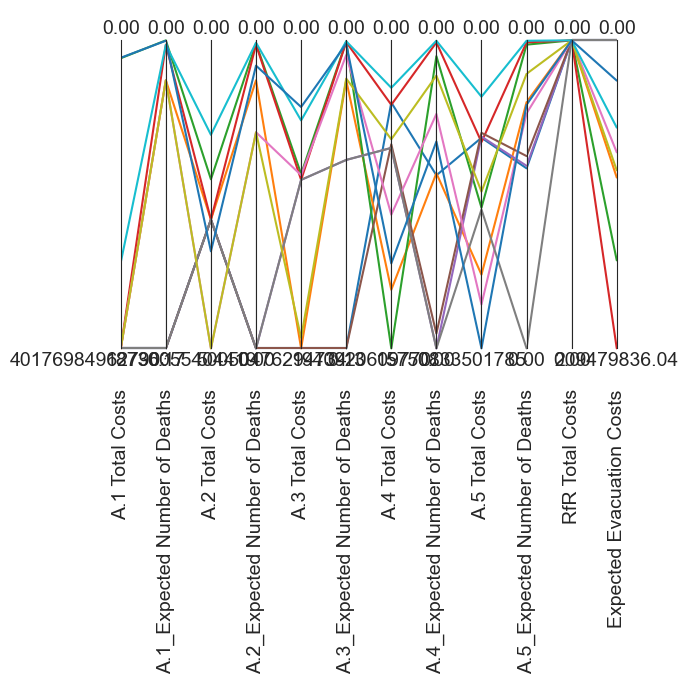

In [30]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, data.columns] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(scores.columns)
plt.show()

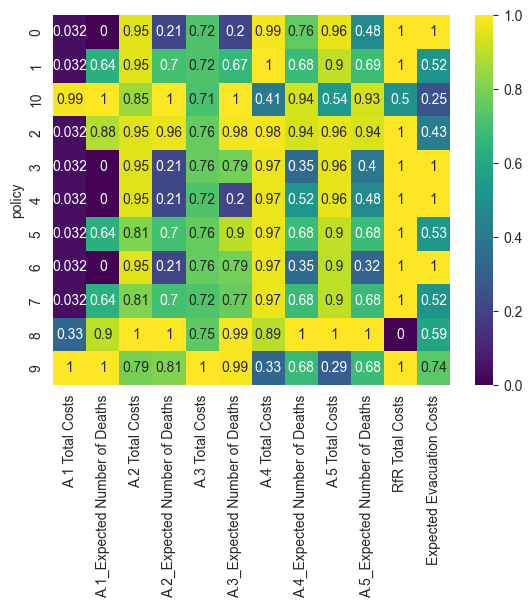

In [31]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model2.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy": experiments['policy'],
                         "scenario": experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret / max_regret.max(), cmap='viridis', annot=True)
plt.show()

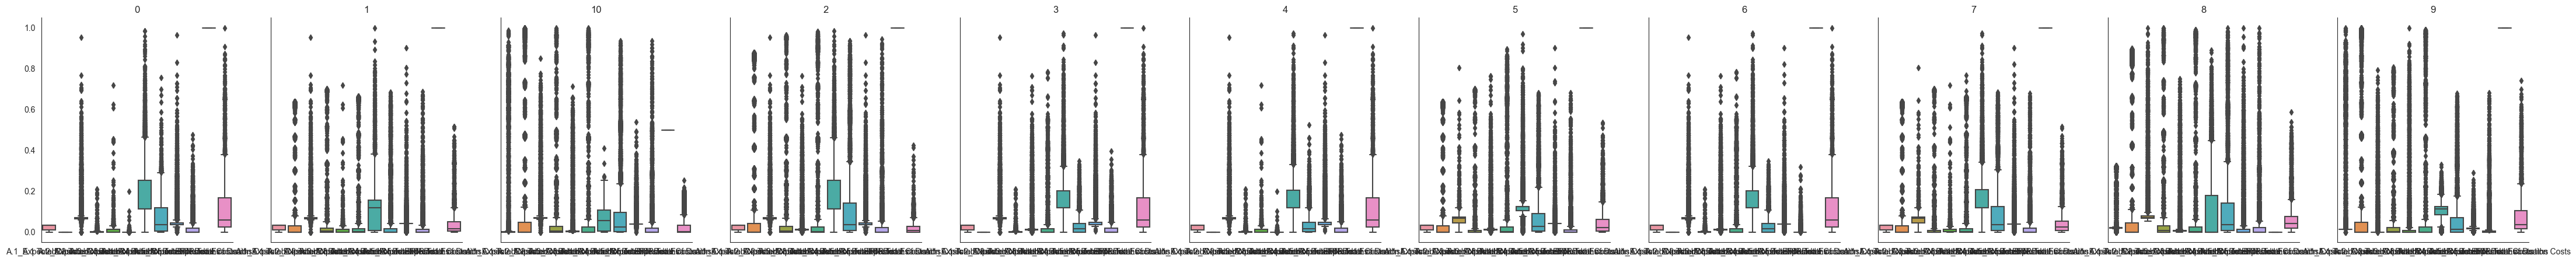

In [34]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

# this generates plots for the 8 policies with a shared y and x axis
fig, axes = plt.subplots(ncols=11, figsize=(55, 5),
                         sharey=True, sharex=True)
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data / max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    sns.despine()
    ax.set_title(str(policy))
plt.savefig('all policy spread.png')
plt.show()